# Задание 6

Изучить поведение FDR для эксперимента из лекции. Рассмотреть случаи, когда количество объектов $m$ варьируется от 200 от 100000. Калибруемые параметры: $m$, $m_0$, $\alpha$.

# Импорт основных библиотек

In [1]:
import numpy as np
import math as m
import matplotlib.pylab as plt
import pandas as pd
import scipy.stats as st
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

# По следам модельного эксперимента


$\mathbf{X}_i \sim \mathcal{N}(0, 1), \quad i=1,\dots,m_0;$

$\mathbf{X}_i \sim \mathcal{N}(1, 1), \quad i=m_0+1,\dots,m;$

$\mathbf{X}_i \in \mathbb{R}^n.$

**Гипотезы:**

$H^i_0: \mathsf{E}\mathbf{X}_i = 0$;

$H^i_1: \mathsf{E}\mathbf{X}_i \neq 0$;

# Сгенерируем данные, пользуясь кодом из лекций. Пока зафиксируем значения $m = 200, m_0 = 150, \alpha = 0.05$, как и в лекционном коде.

In [2]:
m = 200
m0 = 150
n = 20
alpha = 0.05
rs = np.random.RandomState(42)

X = rs.randn(m,n)
X[m0:]+=1

Строим гистограммы

(array([0.01620078, 0.07290352, 0.1636279 , 0.28513376, 0.3564172 ,
        0.36775774, 0.22357079, 0.09720469, 0.03240156, 0.00486023]),
 array([-1.92944869, -1.31219452, -0.69494036, -0.07768619,  0.53956797,
         1.15682214,  1.77407631,  2.39133047,  3.00858464,  3.6258388 ,
         4.24309297]),
 <a list of 10 Patch objects>)

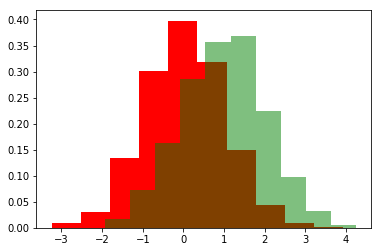

In [3]:
plt.hist(X[:m0].flatten(), color='r', density=True)
plt.hist(X[m0:].flatten(), color='g', alpha=0.5, density=True)

# Подсчёт $FDR$ на конкретной реализации выборки

Для проверки используем одновыборочный критерий Стьюдента. Посчитаем величины $V$ и $R$ в определении $FDR = \mathbb{E}\Bigl(\frac{V}{\max(R,1)}\Bigr)$, где $V$ - количество верных и отвергнутых $H_i, i \in \overline{1, m}$, а $R$ - количество отвергнутых гипотез. Нулевыми гипотезами для наших данных будем считать $H^i_0: \mathsf{E}\mathbf{X}_i = 0$. Если обозначить за $rejected_0$ количество отвергнутых гипотез $H^i_0$ для $i = 1, \dotso, m_0$ (когда они верны) и за $rejected_1$ количество отвергнутых гипотез $H^i_0$ для $i = m_0 + 1, \dotso, m$ (когда они неверны), то в наших условиях $V = rejected_0$, $T = m - m_0 - rejected_1$ (здесь $T$ - количество принятых и неверных гипотез, то есть ошибка второго рода), а $R = rejected_0 + rejected_1$, поэтому $FDR = \mathbb{E}\Bigl(\frac{rejected_0}{\max(rejected_0 + rejected_1,1)}\Bigr)$. Обозначим за $FDR_{\text{experiment}}$ отношение $\frac{rejected_0}{\max(rejected_0 + rejected_1,1)}$ для конкретной реализации выборки $X$. С учётом специфики задачи будем пользоваться восходящими методами множественной проверки гипотезы - Бенджамини-Хохберга и Бенджамини-Иекутиели, которые обеспечивают контроль над $FDR$ при определённых условиях.  

(для одной выборки --- ```st.ttest_1samp```)

# Часть 1. Метод Бенджамини-Хохберга.

In [6]:
# zero mean
p_values = []
for x in X:
    p_values.append(st.ttest_1samp(x, 0)[1])
rejections = multipletests(p_values, method='fdr_bh')[0]

print ('True: H0; H0 not rejected', m0 - rejections[:m0].sum())
print ('True: H0; H0 rejected:',  rejections[:m0].sum())

# non-zero mean
print ('True: H1;  H0 not rejected:', m-m0 - rejections[m0:].sum())
print ('True: H1;  H0 rejected:',  rejections[m0:].sum())

FDR = rejections[:m0].sum()/max(rejections.sum(), 1)
V = rejections[:m0].sum()
T = m - m0 - rejections[m0:].sum()
print("V_experiment = {0}".format(V))
print("T_experiment = {0}".format(T))
print("FDR_experiment = {0}".format(FDR))

True: H0; H0 not rejected 148
True: H0; H0 rejected: 2
True: H1;  H0 not rejected: 7
True: H1;  H0 rejected: 43
V_experiment = 2
T_experiment = 7
FDR_experiment = 0.044444444444444446


Воспользуемся кодом из лекций, который строит графики достигаемых уровней значимостей для метода Бенджамини-Хохберга.

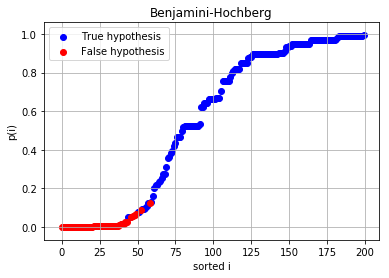

In [7]:
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='fdr_bh')[1]
argsorted_p = np.argsort(p_values)
false = []
true = []
for i, id in enumerate(argsorted_p):   
    if id>m0:
        false.append((i, p_values[id]))
    else:
        true.append((i, p_values[id]))
plt.scatter(*zip(*true), label='True hypothesis', c='b')
plt.scatter(*zip(*false), label='False hypothesis', c='r')
plt.xlabel('sorted i')
plt.ylabel('p(i)')
plt.title('Benjamini-Hochberg')
plt.grid(True)
_=plt.legend(loc='best')

# Подсчёт $FDR$ на большом числе выборок

Итак, мы умеем экспериментально по каждой реализации выборки $X$ считать величину под знаком матожидания. Попробуем посмотреть на величину $\frac{\sum\limits_{i = 1}^{\text{experiments}} FDR_{\text{experiment}}^i}{\text{experiments}}$, то есть среднее число $FDR_{\text{experiments}}$ после реализации выборки $X = (X_1, \dotso, X_m), X_i \in \mathbb{R}^n, i \in \overline{1, m}$ experiments-раз. Закон больших чисел утверждает сходимость по вероятности этой случайной величины к значению $FDR$ при $\text{experiments} \to \infty$. Возьмём experiments = $100$. Пока что зафиксируем счётчик случайности ($42$).

In [9]:
experiments = 100
rs = np.random.RandomState(42)
arr_FDR = []
arr_V = []
arr_T = []
for i in range(experiments):
    X = rs.randn(m,n)
    X[m0:]+=1
    p_values = []
    for x in X:
        p_values.append(st.ttest_1samp(x, 0)[1])
    rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
    FDR = rejections[:m0].sum()/max(rejections.sum(), 1)
    V = rejections[:m0].sum()
    T = m - m0 - rejections[m0:].sum()
    arr_FDR.append(FDR)
    arr_V.append(V)
    arr_T.append(T)

In [10]:
FDR_mean = np.mean(np.array(arr_FDR))
print("FDR_experiment_mean = {0}".format(FDR_mean))

FDR_experiment_mean = 0.04334352128114074


Работает достаточно долго, посмотрим количество экспериментов и сравним результаты для разного числа экспериментов. Код в следующей строчке работает ОЧЕНЬ ДОЛГО.

In [17]:
experiments = np.array([10*(i + 1) for i in range(50)])
rs = np.random.RandomState(42)
arr_FDR = []
for exp in experiments:
    arr_FDR_exp = []
    for i in range(int(exp)):
        X = rs.randn(m,n)
        X[m0:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
        FDR = rejections[:m0].sum()/max(rejections.sum(), 1)
        arr_FDR_exp.append(FDR)
    arr_FDR.append(np.mean(np.array(arr_FDR_exp)))
    print("experiments = {0}".format(exp))

experiments = 10
experiments = 20
experiments = 30
experiments = 40
experiments = 50
experiments = 60
experiments = 70
experiments = 80
experiments = 90
experiments = 100
experiments = 110
experiments = 120
experiments = 130
experiments = 140
experiments = 150
experiments = 160
experiments = 170
experiments = 180
experiments = 190
experiments = 200
experiments = 210
experiments = 220
experiments = 230
experiments = 240
experiments = 250
experiments = 260
experiments = 270
experiments = 280
experiments = 290
experiments = 300
experiments = 310
experiments = 320
experiments = 330
experiments = 340
experiments = 350
experiments = 360
experiments = 370
experiments = 380
experiments = 390
experiments = 400
experiments = 410
experiments = 420
experiments = 430
experiments = 440
experiments = 450
experiments = 460
experiments = 470
experiments = 480
experiments = 490
experiments = 500


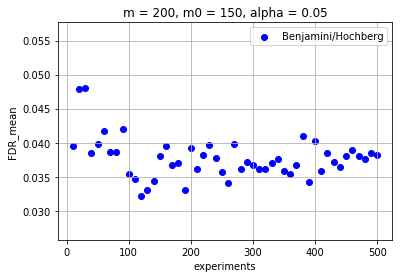

In [18]:
plt.scatter(experiments, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.xlabel('experiments')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.legend()
plt.title('m = {0}, m0 = {1}, alpha = {2}'.format(m, m0, alpha))
plt.show()

In [19]:
experiments

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500])

# Вывод 1: кажется, что среднее число для $FDR$ с ростом числа экспериментов действительно сходится, а его дисперсия уменьшается, хотя и очень медленно. В любом случае, последний график строился не меньше 10 минут, поэтому для экономии времени в дальнейшем будем исследовать для $experiments = 50$.

Сначала посмотрим на зависимость среднего числа для $FDR$ при фиксированном значении $\alpha = 0.05$ при переменном значении $m$, однако, как и в первом эксперименте, оставим соотношение между $m_0$ и $m$ таким же, то есть будем брать $m_0 = \frac{3}{4}m$. По условию, нужно посмотреть на случаи, когда $m$ варьируется от $200$ от $100000$. Разделим этот интервал на $3$ участка, в каждом из которых будет по $8-10$ тестовых точек: от $200$ до $1000$, от $1000$ до $10000$, а также от $10000$ до $100000$. 

In [13]:
arr_m = np.array([100*(i + 1) for i in range(1, 10)])
arr_m0 = np.array([75*(i + 1) for i in range(1, 10)])
alpha = 0.05
experiments = 50
rs = np.random.RandomState(42)
arr_FDR = []
for j in range(arr_m.shape[0]):
    arr_FDR_m = []
    for i in range(experiments):
        X = rs.randn(arr_m[j],n)
        X[arr_m0[j]:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
        FDR = rejections[:arr_m0[j]].sum()/max(rejections.sum(), 1)
        arr_FDR_m.append(FDR)
    arr_FDR.append(np.mean(np.array(arr_FDR_m)))
    print('m = {0}'.format(arr_m[j]))

m = 200
m = 300
m = 400
m = 500
m = 600
m = 700
m = 800
m = 900
m = 1000


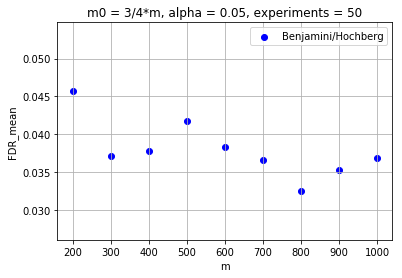

In [16]:
plt.scatter(arr_m, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.xlabel('m')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.title('m0 = 3/4*m, alpha = {0}, experiments = {1}'.format(alpha, experiments))
plt.legend()
plt.show()

Кажется, что никакой явной зависимости нет. Смотрим для интервала от $1000$ до $10000$. Важно: следующая клетка отработала ОЧЕНЬ МЕДЛЕННО, придётся уменьшить количество экспериментов для усреднений до $experiments = 10$, чтобы посмотреть на графики для $m$ от $10000$ до $100000$

In [20]:
arr_m = np.array([1000*(i + 1) for i in range(10)])
arr_m0 = np.array([750*(i + 1) for i in range(10)])
alpha = 0.05
experiments = 50
rs = np.random.RandomState(42)
arr_FDR = []
for j in range(arr_m.shape[0]):
    arr_FDR_m = []
    for i in range(experiments):
        X = rs.randn(arr_m[j],n)
        X[arr_m0[j]:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
        FDR = rejections[:arr_m0[j]].sum()/max(rejections.sum(), 1)
        arr_FDR_m.append(FDR)
    arr_FDR.append(np.mean(np.array(arr_FDR_m)))
    print('m = {0}'.format(arr_m[j]))

m = 1000
m = 2000
m = 3000
m = 4000
m = 5000
m = 6000
m = 7000
m = 8000
m = 9000
m = 10000


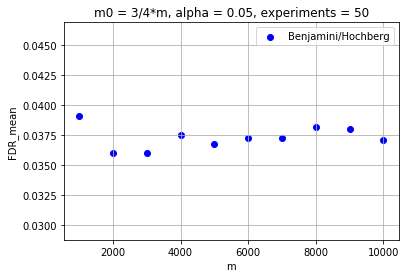

In [21]:
plt.scatter(arr_m, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.xlabel('m')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.legend()
plt.title('m0 = 3/4*m, alpha = {0}, experiments = {1}'.format(alpha, experiments))
plt.show()

Опять непонятно, ситуация не прояснилась, поэтому продолжаем. Следующая клетка тоже работает очень долго.

In [22]:
arr_m = np.array([10000*(i + 1) for i in range(10)])
arr_m0 = np.array([7500*(i + 1) for i in range(10)])
alpha = 0.05
experiments = 10
rs = np.random.RandomState(42)
arr_FDR = []
for j in range(arr_m.shape[0]):
    arr_FDR_m = []
    for i in range(experiments):
        X = rs.randn(arr_m[j],n)
        X[arr_m0[j]:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
        FDR = rejections[:arr_m0[j]].sum()/max(rejections.sum(), 1)
        arr_FDR_m.append(FDR)
    arr_FDR.append(np.mean(np.array(arr_FDR_m)))
    print('m = {0}'.format(arr_m[j]))

m = 10000
m = 20000
m = 30000
m = 40000
m = 50000
m = 60000
m = 70000
m = 80000
m = 90000
m = 100000


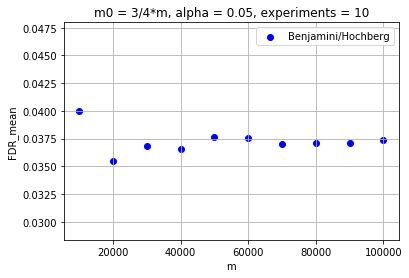

In [23]:
plt.scatter(arr_m, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.legend()
plt.xlabel('m')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.title('m0 = 3/4*m, alpha = {0}, experiments = {1}'.format(alpha, experiments))
plt.show()

# Вывод 2: мы считаем, что в совокупности эти графики не демонстрируют какой-либо явной зависимости среднего $FDR$ от $m$ при выборе $m_0 = \frac{3}{4}m$ (хотя на последнем графике кажется, что точки концентрируются около прямой $FDR_{\text{mean}} = 0.0375$). 
Поэтому перейдём к исследованию зависимости от $m_0$ при фиксированных $m = 1000, experiment = 50, \alpha = 0.05$. Интервал изменений $m_0$ возьмём от $100$ до $900$ с шагом $100$. В дальнейшем посмотрим как будет вести себя метод Бенджамини-Иекутиели для этого случая.

In [73]:
m = 1000
arr_m0 = np.array([100*(i + 1) for i in range(9)])
alpha = 0.05
experiments = 50
rs = np.random.RandomState(42)
arr_FDR = []
for j in range(arr_m0.shape[0]):
    arr_FDR_m0 = []
    for i in range(experiments):
        X = rs.randn(m,n)
        X[arr_m0[j]:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
        FDR = rejections[:arr_m0[j]].sum()/(max(rejections.sum(), 1))
        arr_FDR_m0.append(FDR)
    arr_FDR.append(np.mean(arr_FDR_m0))
    print('m0 = {0}'.format(arr_m0[j]))

m0 = 100
m0 = 200
m0 = 300
m0 = 400
m0 = 500
m0 = 600
m0 = 700
m0 = 800
m0 = 900


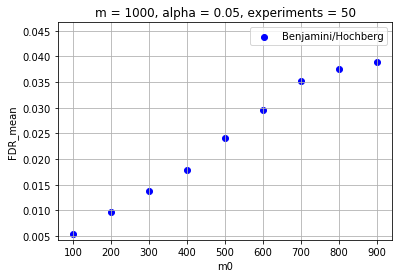

In [74]:
plt.scatter(arr_m0, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.legend()
plt.xlabel('m0')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.title('m = {0}, alpha = {1}, experiments = {2}'.format(m, alpha, experiments))
plt.show()

# Вывод 3: хорошо видна линейная зависимость при фиксированных параметрах $\alpha, m$ величины $FDR_{\text{mean}}$ от $m_0$. 
Переходим к исследованию зависимости этой же величины от $\alpha$ при фиксированных $m$ и $m_0$. Для этого возьмём $\alpha$ в интервале от $0.01$ до $0.1$ при $m = 1000, m_0 = 750$.

In [76]:
m = 1000
m0 = 750
arr_alpha = np.array([i*0.01 for i in range(1, 11)])
experiments = 50
rs = np.random.RandomState(42)
arr_FDR = []
for j in range(arr_alpha.shape[0]):
    arr_FDR_alpha = []
    for i in range(experiments):
        X = rs.randn(m,n)
        X[m0:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=arr_alpha[j], method='fdr_bh')[0]
        FDR = rejections[:m0].sum()/(max(rejections.sum(), 1))
        arr_FDR_alpha.append(FDR)
    arr_FDR.append(np.mean(arr_FDR_alpha))
    print('alpha = {0}'.format(arr_alpha[j]))

alpha = 0.01
alpha = 0.02
alpha = 0.03
alpha = 0.04
alpha = 0.05
alpha = 0.06
alpha = 0.07
alpha = 0.08
alpha = 0.09
alpha = 0.1


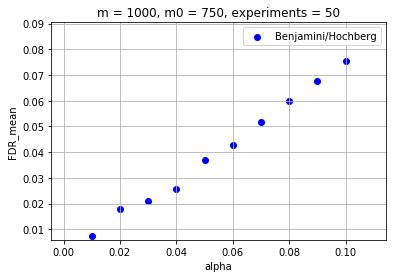

In [77]:
plt.scatter(arr_alpha, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.title('m = {0}, m0 = {1}, experiments = {2}'.format(m, m0, experiments))
plt.show()

# Вывод 4: тоже хорошо видна линейная зависимость при фиксированных параметрах $m_0, m$ величины $FDR_{\text{mean}}$ от $\alpha$. 
Завершим случай исследования метода Бенджамини-Хохберга, зафиксировав значения $\alpha, m_0$ и будем менять $m$ (до этого вместе с $m$ величина $m_0$ тоже менялась, как $m_0 = \frac{3}{4}m$). В качестве параметров возьмём $\alpha = 0.05, m_0 = 100$. Для $m$, как и ранее, построим графики для 3 интервалов - от 200 до 1000, затем от 1000 до 10000, затем от 10000 до 100000. Для первых двух графиков выставим $experiments = 50$, в последнем графике для экономии времени ограничимся $experiments = 10$.

In [80]:
arr_m = np.array([100*(i + 1) for i in range(1, 10)])
m0 = 100
alpha = 0.05
experiments = 50
rs = np.random.RandomState(42)
arr_FDR = []
for j in range(arr_m.shape[0]):
    arr_FDR_m = []
    for i in range(experiments):
        X = rs.randn(arr_m[j],n)
        X[m0:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
        FDR = rejections[:m0].sum()/max(rejections.sum(), 1)
        arr_FDR_m.append(FDR)
    arr_FDR.append(np.mean(np.array(arr_FDR_m)))
    print('m = {0}'.format(arr_m[j]))

m = 200
m = 300
m = 400
m = 500
m = 600
m = 700
m = 800
m = 900
m = 1000


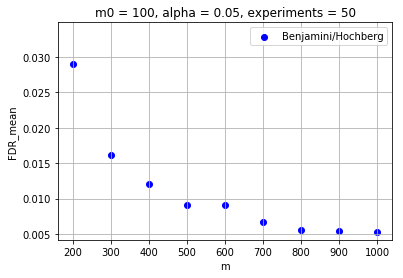

In [81]:
plt.scatter(arr_m, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.xlabel('m')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.legend()
plt.title('m0 = {2}, alpha = {0}, experiments = {1}'.format(alpha, experiments, m0))
plt.show()

 Видно, что с ростом $m$ величина $FDR_{\text{mean}}$ при фиксированных $\alpha, m_0$ убывает. Посмотрим на интервал для $m$ от $1000$ до $10000$.

In [82]:
arr_m = np.array([1000*(i + 1) for i in range(10)])
m0 = 100
alpha = 0.05
experiments = 50
rs = np.random.RandomState(42)
arr_FDR = []
for j in range(arr_m.shape[0]):
    arr_FDR_m = []
    for i in range(experiments):
        X = rs.randn(arr_m[j],n)
        X[m0:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
        FDR = rejections[:m0].sum()/max(rejections.sum(), 1)
        arr_FDR_m.append(FDR)
    arr_FDR.append(np.mean(np.array(arr_FDR_m)))
    print('m = {0}'.format(arr_m[j]))

m = 1000
m = 2000
m = 3000
m = 4000
m = 5000
m = 6000
m = 7000
m = 8000
m = 9000
m = 10000


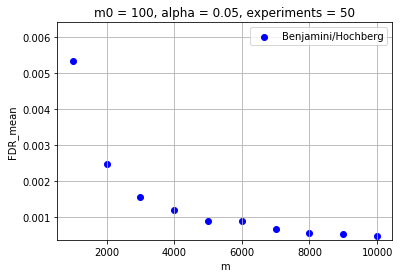

In [83]:
plt.scatter(arr_m, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.xlabel('m')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.legend()
plt.title('m0 = {2}, alpha = {0}, experiments = {1}'.format(alpha, experiments, m0))
plt.show()

Аналогичная закономерность. Переходим к финальному интервалу для $m$ от $10000$ до $100000$, однако уменьшим число экспериментов в усреднении до $experiments = 10$ для экономии времени.

In [84]:
arr_m = np.array([10000*(i + 1) for i in range(10)])
m0 = 100
alpha = 0.05
experiments = 10
rs = np.random.RandomState(42)
arr_FDR = []
for j in range(arr_m.shape[0]):
    arr_FDR_m = []
    for i in range(experiments):
        X = rs.randn(arr_m[j],n)
        X[m0:]+=1
        p_values = []
        for x in X:
            p_values.append(st.ttest_1samp(x, 0)[1])
        rejections = multipletests(p_values, alpha=alpha, method='fdr_bh')[0]
        FDR = rejections[:m0].sum()/max(rejections.sum(), 1)
        arr_FDR_m.append(FDR)
    arr_FDR.append(np.mean(np.array(arr_FDR_m)))
    print('m = {0}'.format(arr_m[j]))

m = 10000
m = 20000
m = 30000
m = 40000
m = 50000
m = 60000
m = 70000
m = 80000
m = 90000
m = 100000


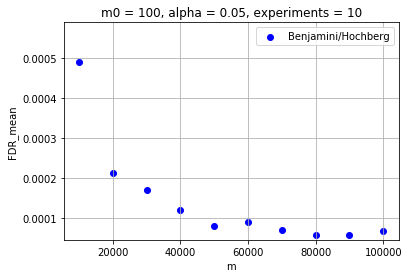

In [85]:
plt.scatter(arr_m, arr_FDR, c='b', label='Benjamini/Hochberg')
plt.xlabel('m')
plt.ylabel('FDR_mean')
plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
plt.grid(True)
plt.legend()
plt.title('m0 = {2}, alpha = {0}, experiments = {1}'.format(alpha, experiments, m0))
plt.show()

# Вывод 5: при фиксированных параметрах $m_0, \alpha$ значение в целом $FDR_{\text{mean}}$ быстро падает с ростом $m$. 
Это может объясняться  тем, что в формуле  $FDR = \mathbb{E}\Bigl(\frac{rejected_0}{\max(rejected_0 + m - m_0 - T,1)}\Bigr)$ величина $m$ стоит в знаменателе. Величина $rejected_0$ при этом ограничена сверху постоянным числом $m_0$.

# Часть 2. Метод Бенджамини-Иекутиели.

Так получилось, что код писался последовательно и имеющийся ноутбук очень вырос по размерам, хотя многие клетки получены из предыдущих заменой нескольких строк кода. К этому моменту было принято решение написать одну функцию, которая будет принимать в качестве параметров метод для функции multitests, тройку массивов для $\alpha, m, m_0$, по которым будет строить график зависимости усреднённого $FDR$ по результатам экспериментов в количестве $experiments$ и в качестве оси $Ox$ будет выбирать один из массивов $\alpha/m/m_0$ (за это отвечает параметр $arr_x$), а также счётчик случайности $random\_state$. Эта функция позволит сократить длину вызовов и не порождать много однотипных клеток. К сожалению, код первой части не переделывали, потому что он писался не один день и все предыдущие клетки работали достаточно долго. Авторы приносят извинения за это.

In [7]:
def plot_graph(n, alpha, m, m0, experiments, method, arr_x, random_state):
    rs = np.random.RandomState(random_state)
    arr_FDR = []
    for j in range(m.shape[0]):
        arr_FDR_exp = []
        for i in range(experiments):
            X = rs.randn(m[j],n)
            X[m0[j]:]+=1
            p_values = []
            for x in X:
                p_values.append(st.ttest_1samp(x, 0)[1])
            rejections = multipletests(p_values, alpha=alpha[j], method=method)[0]
            FDR = rejections[:m0[j]].sum()/max(rejections.sum(), 1)
            arr_FDR_exp.append(FDR)
        arr_FDR.append(np.mean(np.array(arr_FDR_exp)))
        if (arr_x == 'alpha'): 
            print('alpha = {0}'.format(alpha[j]))
        elif (arr_x == 'm'):
            print('m = {0}'.format(m[j]))
        else:
            print('m0 = {0}'.format(m0[j]))
    if (arr_x == 'alpha'): 
        plt.scatter(alpha, arr_FDR, c='b', label=method)
        plt.title('m0 = {0}, m = {1}, experiments = {2}'.format(m0[0], m[0], experiments))
    elif (arr_x == 'm'):
        plt.scatter(m, arr_FDR, c='b', label=method)
        plt.title('m0 = {0}, alpha = {1}, experiments = {2}'.format(m0[0], alpha[0], experiments))
    else:
        plt.scatter(m0, arr_FDR, c='b', label=method)
        plt.title('m = {0}, alpha = {1}, experiments = {2}'.format(m[0], alpha[0], experiments))
    plt.xlabel(arr_x)
    plt.ylabel('FDR_mean')
    plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
    plt.grid(True)
    plt.legend()
    plt.show()

alpha = 0.01
alpha = 0.02
alpha = 0.03
alpha = 0.04
alpha = 0.05
alpha = 0.06
alpha = 0.07
alpha = 0.08
alpha = 0.09
alpha = 0.1


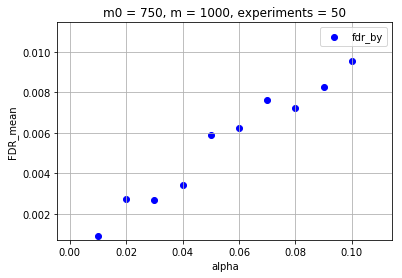

In [8]:
n = 20
m = np.array([1000 for i in range(1, 11)])
m0 = np.array([750 for i in range(1, 11)])
alpha = np.array([i*0.01 for i in range(1, 11)])
experiments = 50
method = 'fdr_by'
random_state = 42
arr_x = 'alpha'
plot_graph(n, alpha, m, m0, experiments, method, arr_x, random_state)

# Вывод 6: здесь также видна линейная зависимость $FDR_{\text{mean}}$ от параметра $\alpha$, хотя  в этом случае она значительно зашумлена по сравнению с методом Бенджамини-Хохберга. 

m0 = 100
m0 = 200
m0 = 300
m0 = 400
m0 = 500
m0 = 600
m0 = 700
m0 = 800
m0 = 900


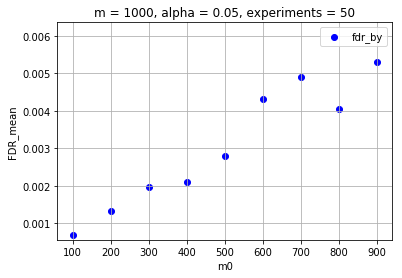

In [9]:
n = 20
m = np.array([1000 for i in range(9)])
m0 = np.array([100*(i + 1) for i in range(9)])
alpha = np.array([0.05 for i in range(9)])
experiments = 50
method = 'fdr_by'
random_state = 42
arr_x = 'm0'
plot_graph(n, alpha, m, m0, experiments, method, arr_x, random_state)

# Вывод 7: здесь тоже если линейная зависимость для $FDR_{\text{mean}}$ от $m_0$ при фиксированных $m, \alpha$ если и есть, то она сильно зашумлена.

m = 200
m = 300
m = 400
m = 500
m = 600
m = 700
m = 800
m = 900
m = 1000


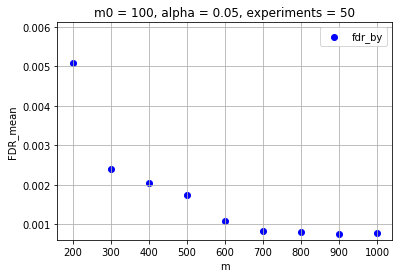

In [11]:
n = 20
m = np.array([100*(i + 1) for i in range(1, 10)])
m0 = np.array([100 for i in range(1, 10)])
alpha = np.array([0.05 for i in range(9)])
experiments = 50
method = 'fdr_by'
random_state = 42
arr_x = 'm'
plot_graph(n, alpha, m, m0, experiments, method, arr_x, random_state)

m = 1000
m = 2000
m = 3000
m = 4000
m = 5000
m = 6000
m = 7000
m = 8000
m = 9000
m = 10000


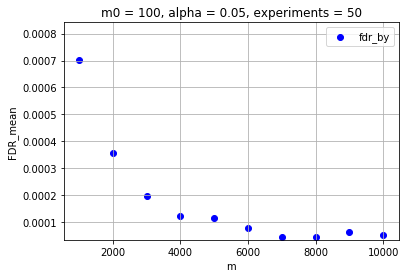

In [12]:
n = 20
m = np.array([1000*(i + 1) for i in range(10)])
m0 = np.array([100 for i in range(10)])
alpha = np.array([0.05 for i in range(10)])
experiments = 50
method = 'fdr_by'
random_state = 42
arr_x = 'm'
plot_graph(n, alpha, m, m0, experiments, method, arr_x, random_state)

# Вывод 8: этот график, как и предыдущий, подтверждает убывающую зависимость $FDR_{\text{mean}}$ от $m$ при фиксированных $m_0, \alpha$. Более того, как и ранее, зависимость кажется гиперболической.
Не будем строить график для $m$ в интервале от $10000$ до $100000$, а лучше попробуем посмотреть, как изменится график для зависимости от $\alpha$, если использовать не один счётчик случайных чисел, а целый набор. Для этого при фиксированных параметрах $m, m_0, \alpha$ возьмём $num\_random\_states$ разных счётчиков случайных чисел, для каждого из них, как и ранее, получим массив $FDR_{\text{mean}}$ усреднением по количеству экспериментов числом $experiments$, а затем усредним соответствующие $num\_random\_states$ чисел, так что на графике будем отображать полученные числа после этих двух последовательных этапов усреднения данных в зависимости от параметра. Это замедлит код в $num\_random\_states$ раз (поэтому на практике возьмём это число не очень большим, скажем, $10$), но позволит учесть "неслучайность" конкретного счётчика данных. Для того, чтобы ждать пришлось не слишком долго, уменьшим число $experiments$ с $50$ до $10$.

In [31]:
def plot_graph_many_random(n, alpha, m, m0, num_random_states, experiments, method, arr_x):
    arr_FDR = []
    for j in range(m.shape[0]):
        arr_FDR_one_random = []
        for k in range(num_random_states):
            arr_FDR_exp = []
            rs = np.random.RandomState(k + 42)
            for i in range(experiments):
                X = rs.randn(m[j],n)
                X[m0[j]:]+=1
                p_values = []
                for x in X:
                    p_values.append(st.ttest_1samp(x, 0)[1])
                rejections = multipletests(p_values, alpha=alpha[j], method=method)[0]
                FDR = rejections[:m0[j]].sum()/max(rejections.sum(), 1)
                arr_FDR_exp.append(FDR)
            arr_FDR_one_random.append(np.mean(np.array(arr_FDR_exp)))
        arr_FDR.append(np.mean(np.array(arr_FDR_one_random)))
        if (arr_x == 'alpha'): 
            print('alpha = {0}'.format(alpha[j]))
        elif (arr_x == 'm'):
            print('m = {0}'.format(m[j]))
        else:
            print('m0 = {0}'.format(m0[j]))
    if (arr_x == 'alpha'): 
        plt.scatter(alpha, arr_FDR, c='b', label=method, color='')
        plt.title('m0 = {0}, m = {1}, experiments = {2}, num_random_states = {3}'.format(m0[0], m[0], experiments,
                                                                                       num_random_states))
    elif (arr_x == 'm'):
        plt.scatter(m, arr_FDR, c='b', label=method)
        plt.title('m0 = {0}, alpha = {1}, experiments = {2}, num_random_states = {3}'.format(m0[0], alpha[0], 
                                                                                    experiments, num_random_states))
    else:
        plt.scatter(m0, arr_FDR, c='b', label=method)
        plt.title('m = {0}, alpha = {1}, experiments = {2}, num_random_states = {3}'.format(m[0], alpha[0], 
                                                                                    experiments, num_random_states))
    plt.xlabel(arr_x)
    plt.ylabel('FDR_mean')
    plt.ylim(0.8*np.min(arr_FDR), 1.2*np.max(arr_FDR)) 
    plt.grid(True)
    plt.legend()
    plt.show()

alpha = 0.01
alpha = 0.02
alpha = 0.03
alpha = 0.04
alpha = 0.05
alpha = 0.06
alpha = 0.07
alpha = 0.08
alpha = 0.09
alpha = 0.1


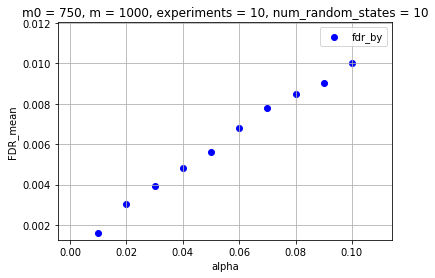

In [34]:
n = 20
m = np.array([1000 for i in range(1, 11)])
m0 = np.array([750 for i in range(1, 11)])
alpha = np.array([i*0.01 for i in range(1, 11)])
experiments = 10
num_random_states = 10
method = 'fdr_by'
arr_x = 'alpha'
plot_graph_many_random(n, alpha, m, m0, num_random_states, experiments, method, arr_x)

# Вывод 9: если сравнить последний график с тем, когда использовали $experiments = 50$, но с одним и тем же счётчиком случайных чисел, то можно заметить, что последняя зависимость с использованием многих счётчиков случайных чисел и меньшим числом $experiments = 10$ куда менее зашумлена от линейной. Это подтверждает наше предположение о том как можно устранить "неслучайность", связанную с конкретным генератором случайных чисел.
Проверим последний вывод при изменении параметра $m_0$ и фиксированных $\alpha, m$.

m0 = 100
m0 = 200
m0 = 300
m0 = 400
m0 = 500
m0 = 600
m0 = 700
m0 = 800
m0 = 900


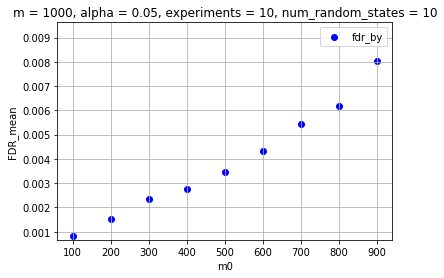

In [36]:
n = 20
m = np.array([1000 for i in range(9)])
m0 = np.array([100*(i + 1) for i in range(9)])
alpha = np.array([0.05 for i in range(9)])
experiments = 10
method = 'fdr_by'
num_random_states = 10
arr_x = 'm0'
plot_graph_many_random(n, alpha, m, m0, num_random_states, experiments, method, arr_x)

# Вывод 10: снова наблюдаем закономерность снятия зашумлённости увеличением количества счётчиков случайных чисел и линейную зависимость $FDR_{\text{mean}}$ от $m_0$ при фиксированных параметрах $m, \alpha$.
В качестве завершения исследования сравним как ведут себя зависимости $FDR_{\text{mean}}$ от $\alpha$ и $m_0$ при фиксированных остальных параметров для двух методов (Бенджамини-Хохберга и Бенджамини-Иекутиели) на одном графике с использованием метода усреднения по нескольким счётчикам случайных чисел. Для обоих методов будем использовать $num\_random\_states = 10$ и $experiments = 10$.

# Часть 3. Сравнение методов Бенджамини-Хохберга и Бенджамини-Иекутиели

In [17]:
def plot_graph_2_methods(n, alpha, m, m0, num_random_states, experiments, method1, method2, arr_x):
    methods = [method1, method2]
    ans = []
    for l in range(2):
        arr_FDR = []
        for j in range(m.shape[0]):
            arr_FDR_one_random = []
            for k in range(num_random_states):
                arr_FDR_exp = []
                rs = np.random.RandomState(k + 42)
                for i in range(experiments):
                    X = rs.randn(m[j],n)
                    X[m0[j]:]+=1
                    p_values = []
                    for x in X:
                        p_values.append(st.ttest_1samp(x, 0)[1])
                    rejections = multipletests(p_values, alpha=alpha[j], method=methods[l])[0]
                    FDR = rejections[:m0[j]].sum()/max(rejections.sum(), 1)
                    arr_FDR_exp.append(FDR)
                arr_FDR_one_random.append(np.mean(np.array(arr_FDR_exp)))
            arr_FDR.append(np.mean(np.array(arr_FDR_one_random)))
            if (arr_x == 'alpha'): 
                print('method = {0}, alpha = {1}'.format(methods[l], alpha[j]))
            elif (arr_x == 'm0'):
                print('method = {0}, m0 = {1}'.format(methods[l], m0[j]))
        ans.append(arr_FDR)
        if (arr_x == 'alpha'):
            if (l == 0):
                plt.scatter(alpha, arr_FDR, c='b', label=methods[l])
            if (l == 1):
                plt.scatter(alpha, arr_FDR, c='r', label=methods[l])
            plt.title('m0 = {0}, m = {1}, experiments = {2}, num_random_states = {3}'.format(m0[0], m[0], experiments,
                                                                                       num_random_states))
        elif (arr_x == 'm0'):
            if (l == 0):
                plt.scatter(m0, arr_FDR, c='b', label=methods[l])
            if (l == 1):
                plt.scatter(m0, arr_FDR, c='r', label=methods[l])
            plt.title('m = {0}, alpha = {1}, experiments = {2}, num_random_states = {3}'.format(m[0], alpha[0], 
                                                                                    experiments, num_random_states))
    plt.xlabel(arr_x)
    plt.ylabel('FDR_mean') 
    plt.grid(True)
    plt.legend()
    plt.show()
    return ans[0], ans[1]

method = fdr_bh, alpha = 0.01
method = fdr_bh, alpha = 0.02
method = fdr_bh, alpha = 0.03
method = fdr_bh, alpha = 0.04
method = fdr_bh, alpha = 0.05
method = fdr_bh, alpha = 0.06
method = fdr_bh, alpha = 0.07
method = fdr_bh, alpha = 0.08
method = fdr_bh, alpha = 0.09
method = fdr_bh, alpha = 0.1
method = fdr_by, alpha = 0.01
method = fdr_by, alpha = 0.02
method = fdr_by, alpha = 0.03
method = fdr_by, alpha = 0.04
method = fdr_by, alpha = 0.05
method = fdr_by, alpha = 0.06
method = fdr_by, alpha = 0.07
method = fdr_by, alpha = 0.08
method = fdr_by, alpha = 0.09
method = fdr_by, alpha = 0.1


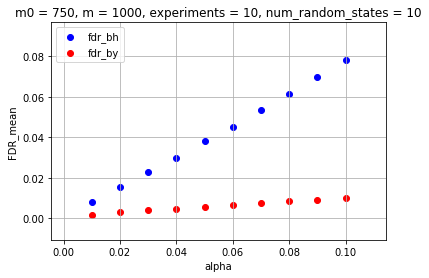

In [18]:
n = 20
m = np.array([1000 for i in range(1, 11)])
m0 = np.array([750 for i in range(1, 11)])
alpha = np.array([i*0.01 for i in range(1, 11)])
experiments = 10
num_random_states = 10
method1 = 'fdr_bh'
method2 = 'fdr_by'
arr_x = 'alpha'
bh, by = plot_graph_2_methods(n, alpha, m, m0, num_random_states, experiments, method1, method2, arr_x)

method = fdr_bh, m0 = 100
method = fdr_bh, m0 = 200
method = fdr_bh, m0 = 300
method = fdr_bh, m0 = 400
method = fdr_bh, m0 = 500
method = fdr_bh, m0 = 600
method = fdr_bh, m0 = 700
method = fdr_bh, m0 = 800
method = fdr_bh, m0 = 900
method = fdr_by, m0 = 100
method = fdr_by, m0 = 200
method = fdr_by, m0 = 300
method = fdr_by, m0 = 400
method = fdr_by, m0 = 500
method = fdr_by, m0 = 600
method = fdr_by, m0 = 700
method = fdr_by, m0 = 800
method = fdr_by, m0 = 900


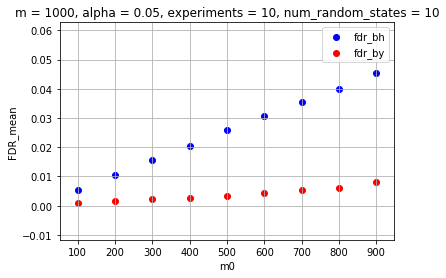

In [19]:
n = 20
m = np.array([1000 for i in range(9)])
m0 = np.array([100*(i + 1) for i in range(9)])
alpha = np.array([0.05 for i in range(9)])
experiments = 10
num_random_states = 10
method1 = 'fdr_bh'
method2 = 'fdr_by'
arr_x = 'm0'
bh, by = plot_graph_2_methods(n, alpha, m, m0, num_random_states, experiments, method1, method2, arr_x)

# Вывод 11: на том же уровне значимости $\alpha$ метод Бенджамини-Иекутиели даёт намного меньшее значение для среднего значения $FDR$, чем метод Бенджамини-Хохберга. 